## <center>Fama French Regression</center>

### <center>Get, Format and Check the Data</center>

In [1]:
from helpers import *

returns_portfolio = pd.read_excel('data/NewBloomMonthlyReturns.xlsx', index_col=0, parse_dates=True)
factor_data = pd.read_excel('data_copulas/bloom_Factor_UpsideRatio.xlsx', index_col=0, parse_dates=True)
factor_data = factor_data.loc['2006-07-01':'2016-06-01'] # The previous month is used to calculate current month

fama_french_3_factor = pd.read_excel('data/FF_RF.xlsx', index_col=0, parse_dates=True)

fama_french_3_factor = fama_french_3_factor / 100
risk_free_rate = fama_french_3_factor[['RF']]

returns_portfolio.index = returns_portfolio.index.to_period('M')
risk_free_rate.index = risk_free_rate.index.to_period('M')
fama_french_3_factor.index = fama_french_3_factor.index.to_period('M')
factor_data.index = factor_data.index.to_period('M')

print("Before Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, factor_data)

# Drop NA's
no_lag_factor_data = factor_data
# Drop columns which are not in both
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
returns_portfolio = returns_portfolio.drop(columns=set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
factor_data = factor_data.drop(columns=set(factor_data.columns).difference(set(returns_portfolio.columns)))
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)), '\n')

print("After Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, no_lag_factor_data)

# Check if returns and Rf have same decimal format side by side
print(returns_portfolio.iloc[:, :2].head(), '\n')
print(fama_french_3_factor.head())

Before Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 93)
Factor First Date: 2006-07 Last Date: 2016-06 Shape: (120, 94) 

Columns not in both {'T', 'EP', 'IHRT', 'LU', 'BHI '}
Columns not in both set() 

After Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 88)
Factor First Date: 2006-07 Last Date: 2016-06 Shape: (120, 94) 

              AXP        VZ
Date                       
2006-07 -0.019001  0.022239
2006-08  0.009219  0.040212
2006-09  0.067378  0.055430
2006-10  0.033583  0.007432
2006-11  0.015741 -0.019984 

         Mkt-RF     SMB     HML      RF
Date                                   
2006-07 -0.0078 -0.0398  0.0260  0.0040
2006-08  0.0203  0.0103 -0.0206  0.0042
2006-09  0.0184 -0.0136  0.0008  0.0041
2006-10  0.0323  0.0175 -0.0031  0.0041
2006-11  0.0171  0.0070  0.0014  0.0042


### <center>Run the Backtest by Sorting each June by Factor</center>

In [2]:
top_20_portfolio_returns = pd.DataFrame(index=returns_portfolio.index)
bottom_20_portfolio_returns = pd.DataFrame(index=returns_portfolio.index)
long_short_portfolio_returns = pd.DataFrame(index=returns_portfolio.index)
short_long_portfolio_returns = pd.DataFrame(index=returns_portfolio.index)
equally_weighted_portfolio_returns = pd.DataFrame(index=returns_portfolio.index)

# Get returns for an equally weighted portfolio holding all stocks
equally_weighted_portfolio_returns['Monthly Returns'] = returns_portfolio.mean(axis=1)

for year in returns_portfolio.index.year.unique():
    start_date = pd.Timestamp(f'{year-1}-07-01')
    end_date = pd.Timestamp(f'{year}-06-01')
    
    # Exclude stocks not IPOed or delisted before the formation period
    valid_stocks = returns_portfolio.loc[start_date:end_date].dropna(axis=1, how='all').columns
    factor = factor_data.loc[start_date:end_date, valid_stocks].mean(axis=0)

    top_20 = factor.sort_values(ascending=False).head(20).index
    bottom_20 = factor.sort_values(ascending=True).head(20).index
    print(f'Current Year {year} - Top 20: {start_date}, Bottom 20: {end_date}')

    for month in returns_portfolio.loc[start_date:end_date].index:
        # Fill NA values with zero for stocks that got delisted during the period
        monthly_returns = returns_portfolio.loc[month].fillna(0)
        
        top_20_mean = monthly_returns[top_20].mean()
        bottom_20_mean = monthly_returns[bottom_20].mean()
        long_short = top_20_mean - bottom_20_mean
        short_long = bottom_20_mean - top_20_mean

        top_20_portfolio_returns.loc[month, 'Monthly Returns'] = top_20_mean
        bottom_20_portfolio_returns.loc[month, 'Monthly Returns'] = bottom_20_mean
        long_short_portfolio_returns.loc[month, 'Monthly Returns'] = long_short
        short_long_portfolio_returns.loc[month, 'Monthly Returns'] = short_long

Current Year 2006 - Top 20: 2005-07-01 00:00:00, Bottom 20: 2006-06-01 00:00:00
Current Year 2007 - Top 20: 2006-07-01 00:00:00, Bottom 20: 2007-06-01 00:00:00
Current Year 2008 - Top 20: 2007-07-01 00:00:00, Bottom 20: 2008-06-01 00:00:00
Current Year 2009 - Top 20: 2008-07-01 00:00:00, Bottom 20: 2009-06-01 00:00:00
Current Year 2010 - Top 20: 2009-07-01 00:00:00, Bottom 20: 2010-06-01 00:00:00
Current Year 2011 - Top 20: 2010-07-01 00:00:00, Bottom 20: 2011-06-01 00:00:00
Current Year 2012 - Top 20: 2011-07-01 00:00:00, Bottom 20: 2012-06-01 00:00:00
Current Year 2013 - Top 20: 2012-07-01 00:00:00, Bottom 20: 2013-06-01 00:00:00
Current Year 2014 - Top 20: 2013-07-01 00:00:00, Bottom 20: 2014-06-01 00:00:00
Current Year 2015 - Top 20: 2014-07-01 00:00:00, Bottom 20: 2015-06-01 00:00:00
Current Year 2016 - Top 20: 2015-07-01 00:00:00, Bottom 20: 2016-06-01 00:00:00


### <center>Plot the Spread Between Top and Bottom 20 Portfolio Cumulative Returns</center>

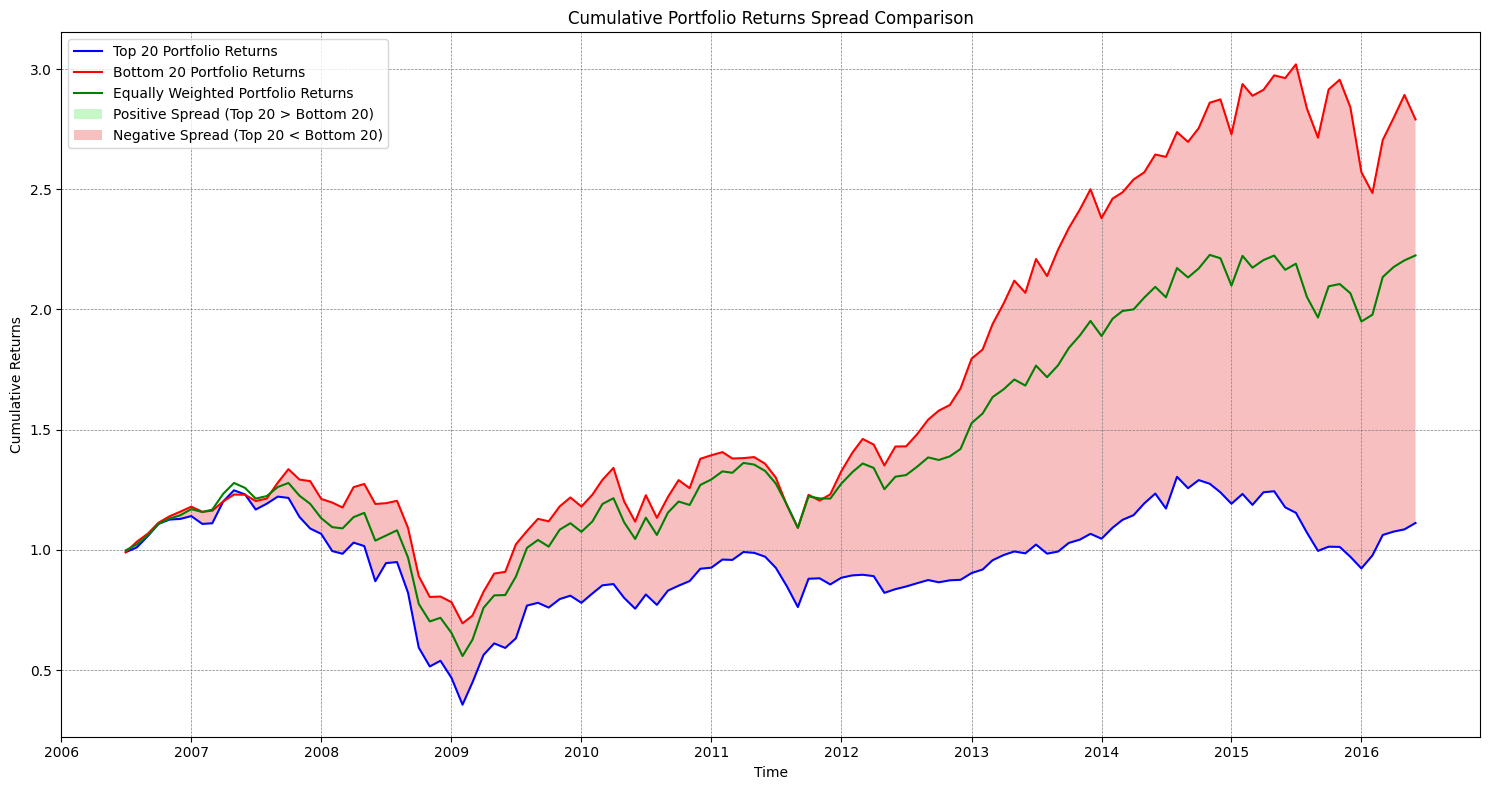

In [3]:
# Calculate the cumulative returns
top_20_portfolio_returns['Cumulative Returns'] = (1 + top_20_portfolio_returns['Monthly Returns']).cumprod()
bottom_20_portfolio_returns['Cumulative Returns'] = (1 + bottom_20_portfolio_returns['Monthly Returns']).cumprod()
long_short_portfolio_returns['Cumulative Returns'] = (1 + long_short_portfolio_returns['Monthly Returns']).cumprod()
short_long_portfolio_returns['Cumulative Returns'] = (1 + short_long_portfolio_returns['Monthly Returns']).cumprod()
equally_weighted_portfolio_returns['Cumulative Returns'] = (1 + equally_weighted_portfolio_returns['Monthly Returns']).cumprod()

#! Maybe not ew but the market from the fama french 3 factor
plot_spread_cumulative_returns(top_20_portfolio_returns, bottom_20_portfolio_returns, equally_weighted_portfolio_returns)

### <center>Plot the Cumulative Returns of the Long-short and Short-long Portfolios</center>

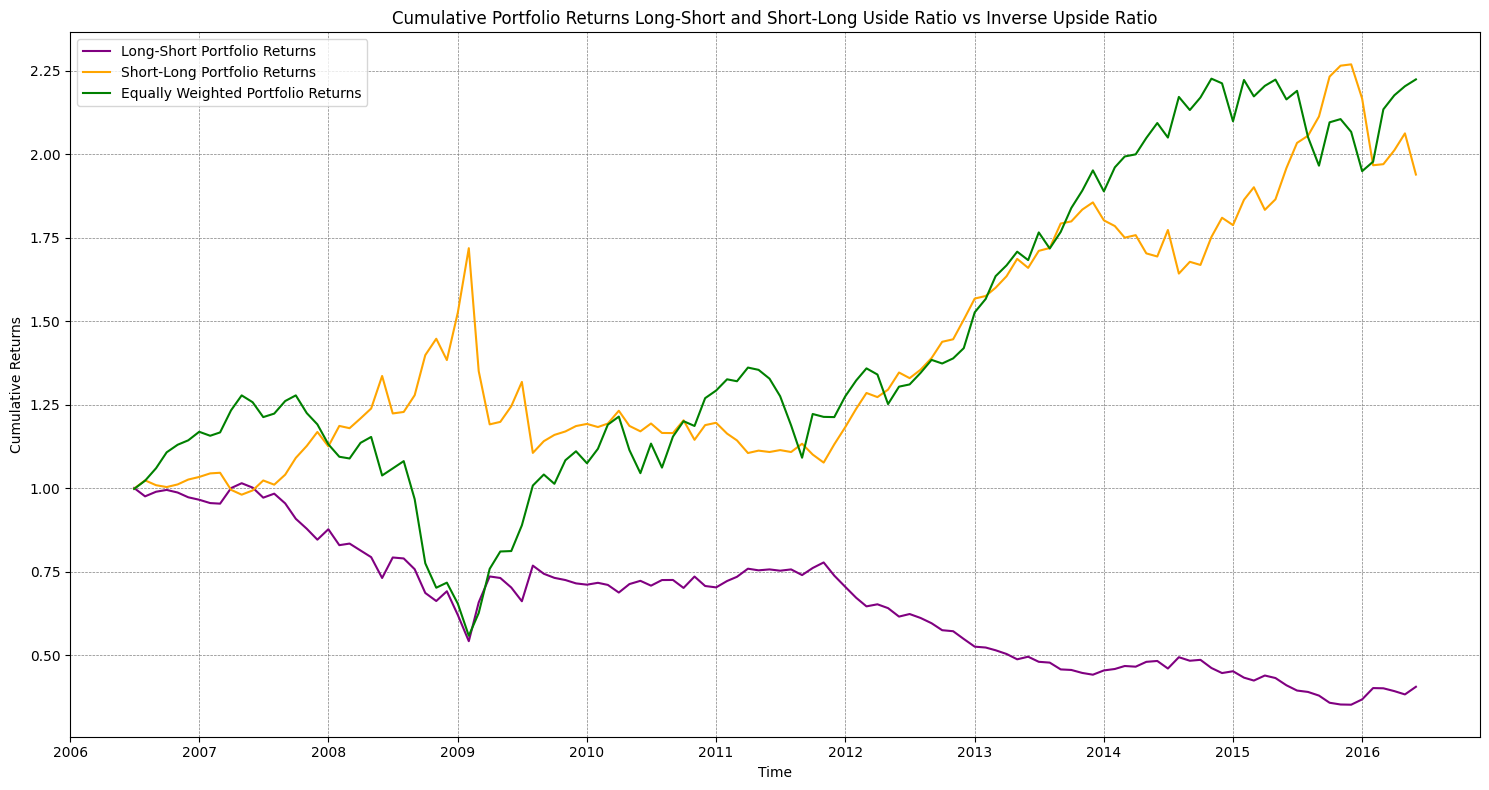

In [4]:
plot_cumulative_returns(long_short_portfolio_returns, short_long_portfolio_returns, equally_weighted_portfolio_returns)

### <center>Get Excess Returns for Fama French Regression</center>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


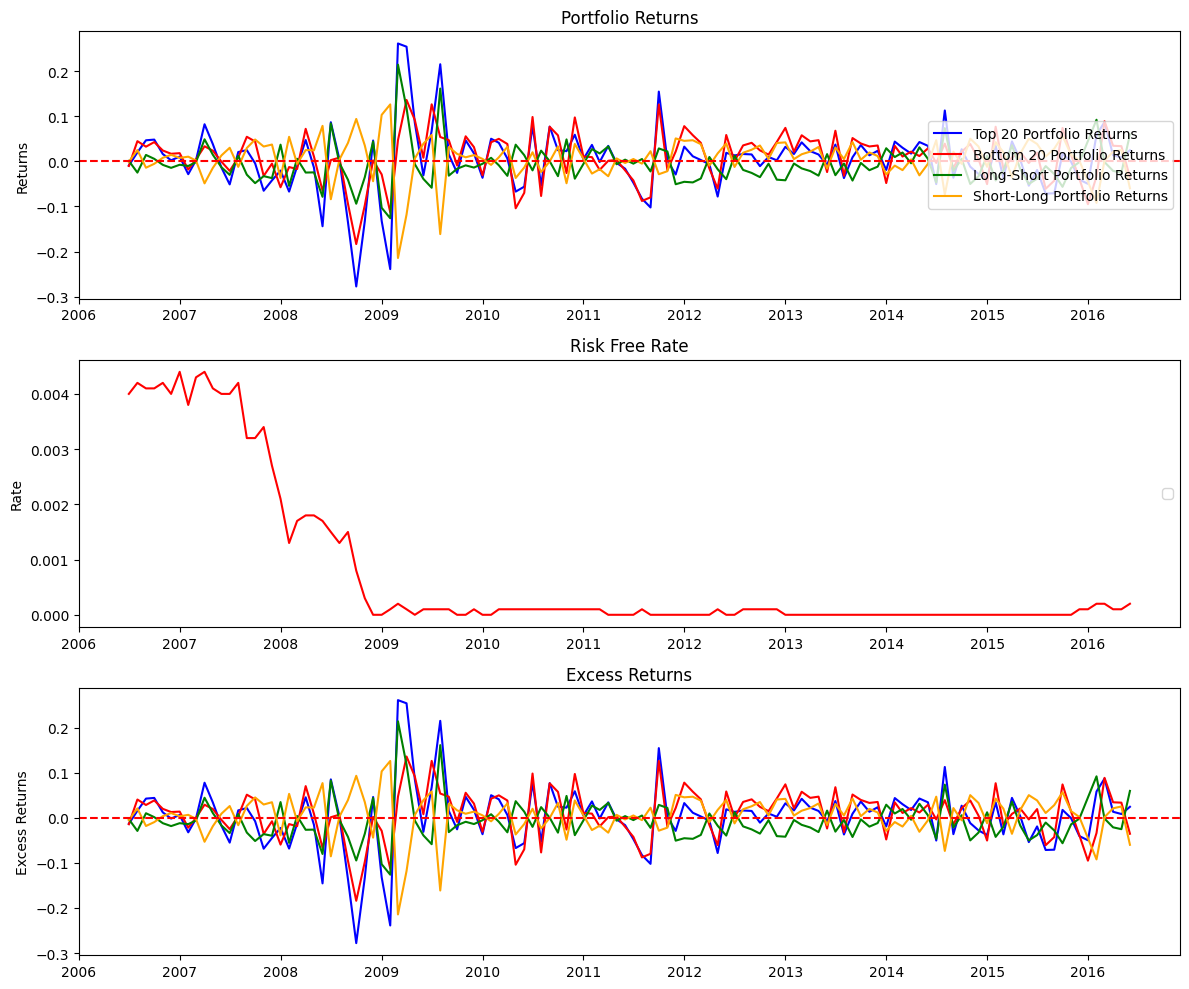

In [5]:
# get excess returns for all portfolios
top_20_portfolio_returns['Excess Returns'] = top_20_portfolio_returns['Monthly Returns'] - risk_free_rate['RF']
bottom_20_portfolio_returns['Excess Returns'] = bottom_20_portfolio_returns['Monthly Returns'] - risk_free_rate['RF']
long_short_portfolio_returns['Excess Returns'] = long_short_portfolio_returns['Monthly Returns'] - risk_free_rate['RF']
short_long_portfolio_returns['Excess Returns'] = short_long_portfolio_returns['Monthly Returns'] - risk_free_rate['RF']

plot_portfolio_portf_rf_excess(top_20_portfolio_returns, bottom_20_portfolio_returns, long_short_portfolio_returns, short_long_portfolio_returns, risk_free_rate)

### <center>Run one Factor Mkt-Rf Fama French Regression</center>

$$
r_{t+k} - r_{f_{t+k}} = \alpha + \beta \times (Mkt-RF) + \epsilon_{t+k}
$$

In [6]:
# Run one factor Fama French regression
fama_french_1_factor = fama_french_3_factor[['Mkt-RF']]
fama_french_1_factor = fama_french_1_factor.loc[top_20_portfolio_returns.index]

def run_one_fama_french_regression(portfolio_returns, factor_data):
    portfolio_returns = portfolio_returns.loc[factor_data.index]
    results = sm.OLS(portfolio_returns['Excess Returns'], sm.add_constant(factor_data)).fit()
    return results

ff_one_top_20_portfolio_results = run_one_fama_french_regression(top_20_portfolio_returns, fama_french_1_factor)
ff_one_bottom_20_portfolio_results = run_one_fama_french_regression(bottom_20_portfolio_returns, fama_french_1_factor)
ff_one_long_short_portfolio_results = run_one_fama_french_regression(long_short_portfolio_returns, fama_french_1_factor)
ff_one_short_long_portfolio_results = run_one_fama_french_regression(short_long_portfolio_returns, fama_french_1_factor)

print(ff_one_top_20_portfolio_results.summary())
print(ff_one_bottom_20_portfolio_results.summary())
print(ff_one_long_short_portfolio_results.summary())
print(ff_one_short_long_portfolio_results.summary())

                            OLS Regression Results                            
Dep. Variable:         Excess Returns   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     333.1
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           3.70e-36
Time:                        00:01:35   Log-Likelihood:                 227.99
No. Observations:                 120   AIC:                            -452.0
Df Residuals:                     118   BIC:                            -446.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.003     -1.746      0.0

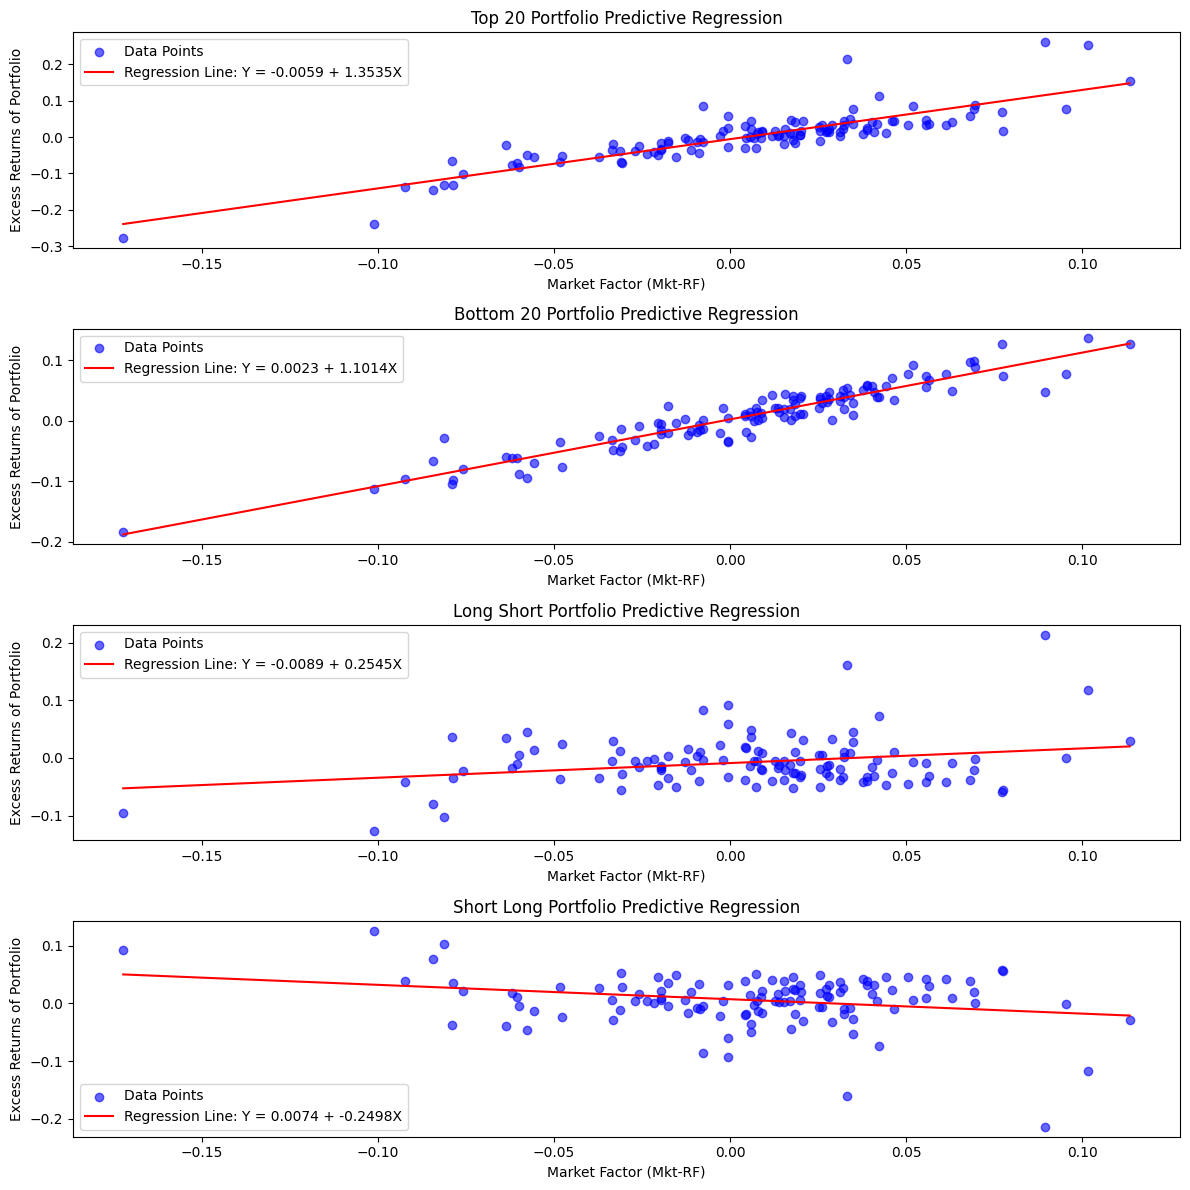

In [7]:
plot_ff_one_predictive_regressions(top_20_portfolio_returns['Excess Returns'], bottom_20_portfolio_returns['Excess Returns'], long_short_portfolio_returns['Excess Returns'], short_long_portfolio_returns['Excess Returns'], fama_french_1_factor)
#plot_ff_one_predictive_regressions_no_labels(top_20_portfolio_returns['Excess Returns'], bottom_20_portfolio_returns['Excess Returns'], long_short_portfolio_returns['Excess Returns'], short_long_portfolio_returns['Excess Returns'], fama_french_1_factor)

### <center>Run Three Factor Mkt-Rf, SMB and HML Fama French Regression</center>

$$
r_{t+k} - r_{f_{t+k}} = \alpha + \beta_1 \times (Mkt-RF) + \beta_2 \times SMB + \beta_3 \times HML + \epsilon_{t+k}
$$

In [8]:
fama_french_3_factor = fama_french_3_factor.loc[top_20_portfolio_returns.index][['Mkt-RF', 'SMB', 'HML']]

def run_three_fama_french_regression(portfolio_returns, factor_data):
    portfolio_returns = portfolio_returns.loc[factor_data.index]
    results = sm.OLS(portfolio_returns['Excess Returns'], sm.add_constant(factor_data)).fit()
    return results

ff_three_top_20_portfolio_results = run_three_fama_french_regression(top_20_portfolio_returns, fama_french_3_factor)
ff_three_bottom_20_portfolio_results = run_three_fama_french_regression(bottom_20_portfolio_returns, fama_french_3_factor)
ff_three_long_short_portfolio_results = run_three_fama_french_regression(long_short_portfolio_returns, fama_french_3_factor)
ff_three_short_long_portfolio_results = run_three_fama_french_regression(short_long_portfolio_returns, fama_french_3_factor)

print(ff_three_top_20_portfolio_results.summary())
print(ff_three_bottom_20_portfolio_results.summary())
print(ff_three_long_short_portfolio_results.summary())
print(ff_three_short_long_portfolio_results.summary())

                            OLS Regression Results                            
Dep. Variable:         Excess Returns   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     140.2
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           2.00e-38
Time:                        00:01:38   Log-Likelihood:                 239.44
No. Observations:                 120   AIC:                            -470.9
Df Residuals:                     116   BIC:                            -459.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.264      0.2

### <center>Collect and Format the Results</center>

In [9]:
def get_significance_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

def extract_regression_results(regression_results):
    
    data = {
        "Portfolio": ["Top 20", "Bottom 20", "Long-Short", "Short-Long"],
        "Alpha": [result.params['const'] for result in regression_results],
        "Beta (Market)": [result.params['Mkt-RF'] if 'Mkt-RF' in result.params else None for result in regression_results],
    }

    if 'SMB' in regression_results[0].params:
        data["Beta (SMB)"] = [result.params['SMB'] for result in regression_results]
        data["Beta (HML)"] = [result.params['HML'] for result in regression_results]
    
    data["T-Statistic of Alpha"] = [result.tvalues['const'] for result in regression_results]
    data["P-Value of Alpha"] = [result.pvalues['const'] for result in regression_results]
    data["Significance of Alpha"] = [get_significance_stars(result.pvalues['const']) for result in regression_results]
    data["R-Squared"] = [result.rsquared for result in regression_results]

    return pd.DataFrame(data)

def display_styled_df(df, title="Regression Results"):
    display(df.style.set_table_styles(
        [{'selector': 'th', 'props': [('font-size', '12pt')]}]
    ).set_properties(**{'background-color': 'lightgrey', 'color': 'black', 'border-color': 'white'}).set_caption(title))

one_factor_results = [ff_one_top_20_portfolio_results, ff_one_bottom_20_portfolio_results, 
                      ff_one_long_short_portfolio_results, ff_one_short_long_portfolio_results
                     ]

three_factor_results = [ff_three_top_20_portfolio_results, ff_three_bottom_20_portfolio_results, 
                        ff_three_long_short_portfolio_results, ff_three_short_long_portfolio_results
                       ]

one_factor_results_df = extract_regression_results(one_factor_results)
three_factor_results_df = extract_regression_results(three_factor_results)
display_styled_df(one_factor_results_df, "One Factor Fama-French Regression Results")
display_styled_df(three_factor_results_df, "Three Factor Fama-French Regression Results")


,Portfolio,Alpha,Beta (Market),T-Statistic of Alpha,P-Value of Alpha,Significance of Alpha,R-Squared
0,Top 20,-0.005873,1.353543,-1.745578,0.083487,*,0.738425
1,Bottom 20,0.002271,1.101384,1.403208,0.163181,,0.889825
2,Long-Short,-0.008909,0.254470,-2.253051,0.026104,**,0.067374
3,Short-Long,0.007380,-0.249847,1.865224,0.064634,*,0.065035


,Portfolio,Alpha,Beta (Market),Beta (SMB),Beta (HML),T-Statistic of Alpha,P-Value of Alpha,Significance of Alpha,R-Squared
0,Top 20,-0.003935,1.248843,-0.078008,0.614924,-1.264422,0.208613,,0.783847
1,Bottom 20,0.002461,1.094304,-0.031240,0.065167,1.501102,0.136046,,0.890875
2,Long-Short,-0.007154,0.155867,-0.042219,0.550733,-1.874598,0.063363,*,0.161017
3,Short-Long,0.005638,-0.153210,0.051317,-0.548781,1.475764,0.142717,,0.158238


### <center>Interpretation Summary</center>

**Plot of the Spread between Top and Bottom 20 Portfolios**

- **Plot of Spread:**
  - We see a significant negative spread, indicating that the Bottom 20 portfolio outperforms the Top 20 portfolio, suggesting that the Bottom 20 portfolio has a higher return than the Top 20 portfolio. The returns of the Equally weighted Portfolio are in between the Top 20 and Bottom 20 portfolios. The high spread between the Top 20 and Bottom 20 portfolios indicates that the inverse Upside Ratio can be used to sort the stocks and is a good predictor of future returns.

- **Plot of Long-Short Portfolios:**
  - The Long-Short Portfolio (long in top 20 and short in bottom 20) has a negative cumulative return. Conversely, the Short-Long Portfolio (short in top 20 and long in bottom 20) has a positive cumulative return and performs similarly, yet slightly worse compared to the market in terms of absolute performance. However, the Short-Long Portfolio appears less volatile than the market, even bridging the financial crisis in 2008 with only a small decline.

- **Meaning for the Upside Ratio:**
  - It appears that the inverse of the factor is working, potentially due to mean reversion. Hence, when stocks have a higher correlation of negative returns than positive returns with the market, they tend to perform better in the future. This could be due to the fact that the market is more likely to overreact to negative news than positive news, hence the stocks that have a higher correlation of negative returns with the market are more likely to be undervalued and revert back to their mean after the 5-month window used to calculate the ratio.

**One-Factor Fama-French Regression Results (CAPM)**

- **Top 20 Portfolio:**
  - **Alpha:** -0.005873
  - **Significance:** Marginally significant (P-value: 0.083; T-statistic: -1.746). This suggests that the portfolio does not generate significant abnormal returns above the market.
  - **R-Squared:** 0.738, indicating substantial market dependence.

- **Bottom 20 Portfolio:**
  - **Alpha:** 0.002271
  - **Significance:** Not statistically significant (P-value: 0.163; T-statistic: 1.403). Suggests potential small abnormal positive returns, though not significant.
  - **R-Squared:** 0.890, suggesting high market sensitivity.

- **Long-Short Portfolio:**
  - **Alpha:** -0.008909
  - **Significance:** Statistically significant (P-value: 0.026; T-statistic: -2.253), indicating significant underperformance relative to the market.
  - **R-Squared:** 0.067, indicating the market factor does not well explain the returns.

- **Short-Long Portfolio:**
  - **Alpha:** 0.007380
  - **Significance:** Marginally significant (P-value: 0.065; T-statistic: 1.865). Indicates potential small abnormal positive returns.
  - **R-Squared:** 0.065, similarly low, indicating market movements do not well explain its performance.

**Three-Factor Fama-French Regression Results**

- **Top 20 Portfolio:**
  - **Alpha:** -0.003935
  - **Significance:** Not statistically significant (P-value: 0.209; T-statistic: -1.264). Shows no alpha in a multifactor model.
  - **R-Squared:** 0.784, indicating that adding SMB and HML factors slightly improves the model fit.

- **Bottom 20 Portfolio:**
  - **Alpha:** 0.002461
  - **Significance:** Not statistically significant (P-value: 0.136; T-statistic: 1.501). Indicates no significant abnormal returns.
  - **R-Squared:** 0.891, showing these factors explain a great deal of the variance.

- **Long-Short Portfolio:**
  - **Alpha:** -0.007154
  - **Significance:** Marginally significant (P-value: 0.063; T-statistic: -1.875). The negative alpha suggests underperformance.
  - **R-Squared:** 0.161, indicating little change from the one-factor model.

- **Short-Long Portfolio:**
  - **Alpha:** 0.005638
  - **Significance:** Not significant (P-value: 0.143; T-statistic: 1.476). This result is consistent with the one-factor analysis, showing no significant abnormal performance.
  - **R-Squared:** 0.158, indicating a minor influence of the SMB and HML factors.

### <center>Conclusion</center>
These analyses demonstrate how alpha significance changes under different factor models. The Bottom 20 portfolio consistently shows some capacity for abnormal positive returns, especially under the three-factor model, suggesting it benefits from specific characteristics not captured by market movements alone. Conversely, the Long-Short portfolio consistently underperforms across both models, indicating that the strategy does not capitalize effectively on market inefficiencies. The Top 20 and Short-Long portfolios do not exhibit significant alpha, suggesting they track closer to market performance without distinct advantages from either their market capitalization or book-to-market ratios. These insights underline the importance of factor analysis in understanding portfolio performances and crafting investment strategies.